# _hkl_ trajectory calculation: compare with SPEC results

## Initial setup

### Initialize the MatPlotLib graphics

In [1]:
%matplotlib inline

### Import support libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gi
gi.require_version('Hkl', '5.0')
from hkl.calc import CalcE6C

### Load the desired _hkl_ trajectory data.

In [3]:
hkls = pd.read_csv('./hkl_data/hkl.txt', delim_whitespace=True)
hkls.keys()

Index(['h', 'k', 'l'], dtype='object')

### Plot the desired _hkl_ trajectory

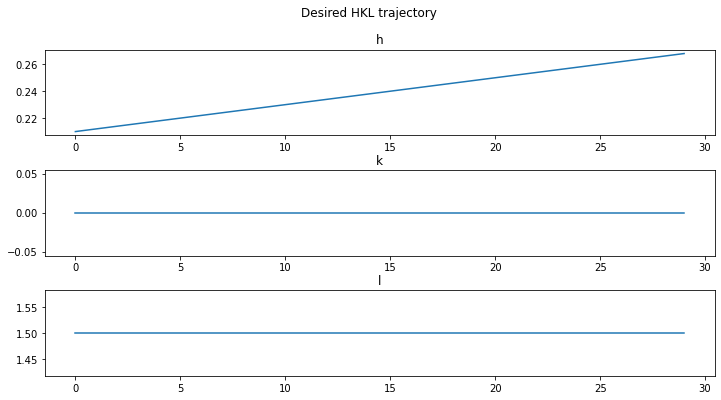

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

plt.suptitle('Desired HKL trajectory')
axes[0].plot(hkls.h)
axes[0].set_title('h')
axes[1].plot(hkls.k)
axes[1].set_title('k')
axes[2].plot(hkls.l)
axes[2].set_title('l')
plt.show()

### Get the motor positions calculated by SPEC

In [5]:
spec_motors = pd.read_csv('hkl_data/motors.txt', delim_whitespace=True)
spec_motors.keys()

Index(['Delta', 'Theta', 'Chi', 'Phi', 'Mu', 'Gamma'], dtype='object')

### Plot the trajectory of the physical motors calculated by SPEC

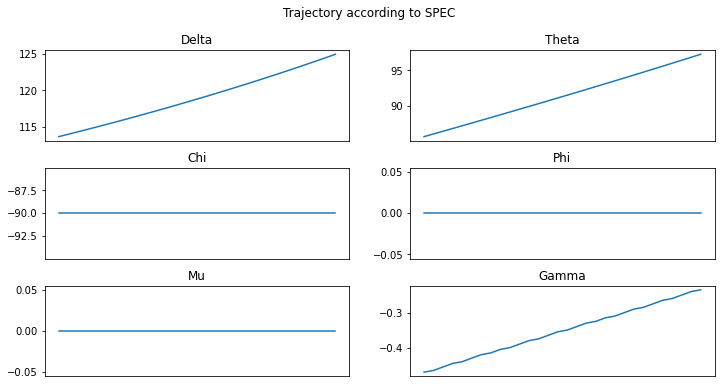

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6),
                         subplot_kw={'xticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plt.suptitle('Trajectory according to SPEC')
for ax, key in zip(axes.flat, spec_motors.keys()):
    ax.plot(spec_motors.index, spec_motors[key], label=key)
    ax.set_title(key)
plt.show()

## Calculate with ***hklpy***

### Initialize a calculation engine for the 6-circle diffractometer geometry

In [7]:
diffractometer = CalcE6C(engine='hkl')
diffractometer.wavelength = 13.3  # angstroms

print('physical axes', diffractometer.physical_axes)
print('pseudo axes', diffractometer.pseudo_axes)
print('omega parameter is', diffractometer['omega'])

physical axes OrderedDict([('mu', 0.0), ('omega', 0.0), ('chi', 0.0), ('phi', 0.0), ('gamma', 0.0), ('delta', 0.0)])
pseudo axes OrderedDict([('h', 0.0), ('k', 0.0), ('l', 0.0)])
omega parameter is CalcParameter(name='omega', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')


### Decide which diffractometer *mode* to use.

The motor trajectories show `delta` (the diffractometer arm) having the greatest variation, `theta` (also known as `omega`, sample rotation colinear with `delta`), also varies but not at half the value of `delta`, and `gamma` moves a small amount.

Need a mode that only moves three axes.  Learn the available modes.

In [8]:
print(diffractometer.engine.modes)

['bissector_vertical', 'constant_omega_vertical', 'constant_chi_vertical', 'constant_phi_vertical', 'lifting_detector_phi', 'lifting_detector_omega', 'lifting_detector_mu', 'double_diffraction_vertical', 'bissector_horizontal', 'double_diffraction_horizontal', 'psi_constant_vertical', 'psi_constant_horizontal', 'constant_mu_horizontal']


In `bissector_vertical`, we expect `delta` to be twice `theta` so that is not the mode.  Continuing along, `lifting_detector_omega` allows the variation seen above.

In [9]:
diffractometer.engine.mode = "lifting_detector_omega"

print('mode is', diffractometer.engine.mode)

mode is lifting_detector_omega


### Apply constraints: restrict the range of allowed positions for some physical motors

Only allow solutions with the values of $\varphi=0$, $\chi=-90$, & $\mu=0$, as in the plots above.  Note: with `chi.fit = False`, no solutions were found in the calculations below.  Only by adjusting the limits of `chi` to a small range and allowing it to be fit, while keeping the final value `chi.value = -90` were the calculations able to resolve the motor positions.

In [10]:
phi = diffractometer['phi']
phi.limits = (0, 0)
phi.value = 0
phi.fit = False

chi = diffractometer['chi']
chi.limits = (-90.01, -89.99)
chi.value = -90
chi.fit = True

mu = diffractometer['mu']
mu.limits = (0, 0)
mu.value = 0
mu.fit = False

delta = diffractometer['delta']
delta.limits = (0, 180)

gamma = diffractometer['gamma']
gamma.limits = (-10, 10)

print('phi', diffractometer['phi'])
print('chi', diffractometer['chi'])
print('mu', diffractometer['mu'])

phi CalcParameter(name='phi', limits=(0.0, 0.0), value=0.0, fit=False, inverted=False, units='Degree')
chi CalcParameter(name='chi', limits=(-90.01, -89.99), value=-90.0, fit=True, inverted=False, units='Degree')
mu CalcParameter(name='mu', limits=(0.0, 0.0), value=0.0, fit=False, inverted=False, units='Degree')


## Sample

### Describe the unit cell and give it a name

Define a hypothetical tetragonal crystal.

In [11]:
from hkl.util import Lattice

lattice = Lattice(a=3.78, b=3.78, c=13.28, alpha=90, beta=90, gamma=90)
sample = diffractometer.new_sample('tetragonal', lattice=lattice)

## Orient the sample on the diffractometer

### Find two reflections and identify _hkl_ of each.

In [12]:
pos1 = diffractometer.Position(mu=0.0, omega=71.04, chi=-90.0, phi=0.0, gamma=-1.65, delta=136.7)
r1 = sample.add_reflection(0, 0, 2, position=pos1)

pos2 = diffractometer.Position(mu=0.0, omega=158.22, chi=-90.0, phi=0.0, gamma=1.7, delta=164.94)
r2 = sample.add_reflection(1, 0, 1, position=pos2)

### Calculate the UB matrix

In [13]:
sample.compute_UB(r1, r2)
print(np.array(sample.UB))

spec_ub = [[0.0338309723166807, 1.6616745234937, -0.00732930331262271],
           [1.66007365775423, -0.032591767600211, 0.0221634966739925],
           [0.0773350510852808, -0.0273010739795478, -0.472555187096841]
           ]
print('from spec:\n', np.array(spec_ub))

[[ 1.66011306  0.0298982   0.02223195]
 [ 0.07775045  0.02016382 -0.4725787 ]
 [-0.03081074  1.6618271   0.00533407]]
from spec:
 [[ 0.03383097  1.66167452 -0.0073293 ]
 [ 1.66007366 -0.03259177  0.0221635 ]
 [ 0.07733505 -0.02730107 -0.47255519]]


## Calculate the motor trajectories from list of _hkl_ positions

In [14]:
print('mode is', diffractometer.engine.mode)

hkl_motors = {nm: [] for nm in diffractometer.physical_axis_names}

for seq, (h, k, l) in hkls.iterrows():
    try:
        solutions = diffractometer.forward((h, k, l))
    except ValueError:
        solutions = []
    for sol in solutions[:1]:   # only show the first solution
        print(f"{seq}  {h,k,l}  {sol}")
        for nm in diffractometer.physical_axis_names:
            hkl_motors[nm].append(getattr(sol, nm))

if len(hkl_motors["delta"]) < len(spec_motors["Delta"]):
    raise ValueError(
        f"Solutions are not comparable. {len(hkl_motors['delta'])} < {len(spec_motors['Delta'])}")

mode is lifting_detector_omega
29  (0.268, 0.0, 1.5)  PosCalcE6C(mu=0.0, omega=97.28279140606712, chi=-90.0, phi=0.0, gamma=0.054224488409117436, delta=124.95837187080619)


ValueError: Solutions are not comparable. 1 < 30

### Plot the motor trajectories according to *hkl*

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6),
                         subplot_kw={'xticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plt.suptitle('Trajectory according to hkl')
for ax, key in zip(axes.flat, diffractometer.physical_axis_names):
    ax.plot(spec_motors.index, trajectory[key], label=key)
    ax.set_title(key)
plt.show()